In [3]:
# validation method for recommender systems
# computes the RMSE (root mean squared error) for the recommender method on the same dataset
# using increasing volume ratio of training/testing dataset
# might be used to evaluate how the method improves on increasing volume on testing dataset

import logging
import math
import pandas as pd
import numpy as np
from recommender.doc2vec_recommender import Doc2VecRecommender as Recommender

# DATA_FILE_PATH="/home/michal/Documents/Misc/recommenders/vcs/book-recommender/data/ratings_Books.csv"
DATA_FILE_PATH = '/home/kvassay/data/book-recommender/ratings_Books.csv'

SAMPLED_USERS = 1000
USER_IS_ROBOT_THRESHOLD = 100

# slices to use for testing methods improvements on increasing amount of testing data
SLICING_INTERVAL = 5

# select how many times the evaluation will split data and test
# selecting 1 means one split with fold on SLICING_INTERVAL-1/SLICING_INTERVAL timestamp for every user
# can automatically test a development of model performance on increasing amount of training data
SLICING_RUNS = 1
SPLIT_Q=0.8
method_name = Recommender.__module__

# logging init:
logger = logging.getLogger()
logger.setLevel(20)

FORMAT = '%(asctime)s.%(msecs)03d - %(levelname)s - %(message)s'
DATE_FORMAT = '%Y-%m-%d %H:%M:%S'
formatter = logging.Formatter(fmt=FORMAT, datefmt=DATE_FORMAT)
handler = logging.StreamHandler()
handler.setFormatter(formatter)
logger.addHandler(handler)

data_file = DATA_FILE_PATH

date_format = "%Y-%m-%d %H:%M:%S"

logger.info("Starting application on %s dataset" % data_file)
logger.info("Testing recommender implementation of %s " % method_name)

with open(data_file, "r") as f:
    df = pd.read_csv(data_file, names=["user", "item", "rating", "timestamp"])

grouped_users = df.groupby(["user"]).count()
n_review_users = grouped_users[grouped_users["item"] >= SLICING_INTERVAL]["item"].keys()
eval_users = np.random.choice(n_review_users.unique(), SAMPLED_USERS)
logger.info("Selected %s users to evaluate their ratings" % eval_users.__len__())

eval_dataframe = df[df['user'].isin(eval_users)]
logger.info("Selected dataframe of random %s users containing %s entries" %
            (eval_users.__len__(), eval_dataframe.__len__()))



training_frame = pd.DataFrame(columns=["user", "item", "rating", "timestamp"])
testing_frame = pd.DataFrame(columns=["user", "item", "rating", "timestamp"])


quantile = SPLIT_Q
logger.info("training on users dataset divides on quantile %s" % quantile)

# TODO: later compare recommender results with using dataset having only data newer than from 2013

for user in eval_users:
    user_reviews = eval_dataframe[eval_dataframe['user'] == user]

    if len(user_reviews) >= USER_IS_ROBOT_THRESHOLD:
        # do not include users having more than threshold ratings
        continue

    # value dividing reviews of a user to training and testing
    slicing_timestamp = user_reviews["timestamp"].quantile(q=quantile)

    training_user_data = user_reviews[user_reviews["timestamp"] < slicing_timestamp]
    training_frame = training_frame.append(training_user_data)

    testing_user_data = user_reviews[user_reviews["timestamp"] >= slicing_timestamp]
    testing_frame = testing_frame.append(testing_user_data)

logger.info("training dataframe size: %s" % training_frame.__len__())
logger.info("testing dataframe size: %s" % testing_frame.__len__())

2016-11-23 21:46:43.536 - INFO - Starting application on /home/kvassay/data/book-recommender/ratings_Books.csv dataset
2016-11-23 21:46:43.537 - INFO - Testing recommender implementation of recommender.doc2vec_recommender 
2016-11-23 21:47:35.624 - INFO - Selected 1000 users to evaluate their ratings
2016-11-23 21:47:36.868 - INFO - Selected dataframe of random 1000 users containing 15083 entries
2016-11-23 21:47:36.870 - INFO - training on users dataset divides on quantile 0.8
2016-11-23 21:47:44.275 - INFO - training dataframe size: 7886
2016-11-23 21:47:44.275 - INFO - testing dataframe size: 3529


In [28]:
class BaselineRecommender:

    mean = 0

    def __init__(self):
        pass

    # expects raw entries in format "user,item,rating,timestamp"
    def fit(self, raw_data):
        #         self.mean = raw_data["rating"].mean()
        #         return True
        pass

    # expects one entry's user and item
    # will return predicted rating which is the only attribute to be used for performance evaluation
    def predict(self, user, item):

        return 4.0


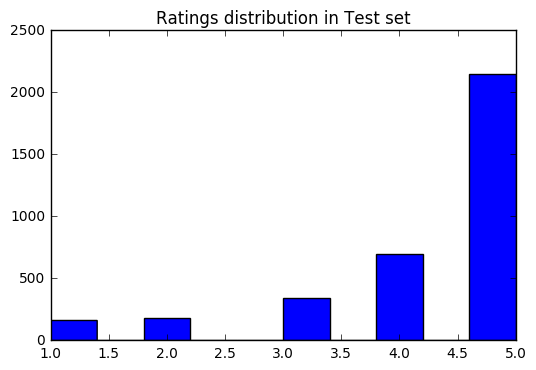

Ratings distribution in Test set: Counter({5.0: 2151, 4.0: 696, 3.0: 339, 2.0: 182, 1.0: 161})


In [29]:
true_ratings=list()
for index, entry in testing_frame.iterrows():
        true_ratings.append(entry["rating"])
plt.hist(true_ratings)
plt.title('Ratings distribution in Test set')
plt.show()

from collections import Counter
print('Ratings distribution in Test set: '+ str(Counter(true_ratings)))

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def evaluate(recommender_instance):
    recommender_instance.fit(training_frame)
    logger.info("Recommender method has fit on %s entries" % training_frame.__len__())

    # aggregated difference of recommender predicted rating against the real rating
    delta_sum = 0
    len_diff = 0
    y_true=list()
    y_pred=list()
    
    for index, entry in testing_frame.iterrows():
        expected_score = entry["rating"]
        actual_score = recommender_instance.predict(entry["user"], entry["item"])

        if actual_score is not None:
            y_true.append(expected_score)
            y_pred.append(actual_score)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [31]:
def get_random_cfg(cfgs):
    cfg=dict()
    for key in cfgs:
        num_options=len(cfgs[key])
        cfg[key]=np.random.choice(cfgs[key],1)[0]
    return cfg

In [44]:
#CFGS={'num_epochs':[1,3,5,7,10], 'alpha':[0.1,0.025,0.15,0.3], 'min_alpha':[0.025,0.01,0.001,0.5], 'dm':[1], 'size':[10,30,50,70,100,150,200,300], 'window':[3,5,8], 'min_count':[1], 'negative':[0,5,10]}
CFGS={'num_epochs':range(1,15,1), 'alpha':[0.025], 'min_alpha':[0.01], 'dm':[1], 'size':range(20,70,5), 'window':range(4,8), 'min_count':[1]}


In [45]:
import time
import matplotlib.pyplot as plt
%matplotlib inline  

TIME_LIMIT_S=60
logger.setLevel(40)
best_cfg=None
best_score=10000
start=time.time()
dummy_rec=BaselineRecommender()
n_iter=1
score_improvements=list()
rec_d=BaselineRecommender()
score_d=evaluate(rec_d)
print('Dummy score: '+str(score_d))
while time.time()-start < TIME_LIMIT_S:
    if n_iter%20==0:
        print('20 iterations passed...')
    cfg=get_random_cfg(CFGS)
    rec=Recommender(cfg)
    score=evaluate(rec)
    if score<best_score:
        best_cfg=cfg
        best_score=score
        score_improvements.append(best_score)
        print('Found new best config in iter No. '+str(n_iter)+' ___________________________')
        print('Best cfg: '+str(best_cfg))
        print('Best score: '+str(best_score))
    n_iter+=1
print('Score improvements: '+str(score_improvements))

Dummy score: 1.14998737165
Found new best config in iter No. 1 ___________________________
Best cfg: {'dm': 1, 'num_epochs': 14, 'window': 7, 'alpha': 0.025000000000000001, 'min_count': 1, 'min_alpha': 0.01, 'size': 55}
Best score: 1.28262551243
Found new best config in iter No. 2 ___________________________
Best cfg: {'dm': 1, 'num_epochs': 11, 'window': 7, 'alpha': 0.025000000000000001, 'min_count': 1, 'min_alpha': 0.01, 'size': 45}
Best score: 1.26949751147


KeyboardInterrupt: 

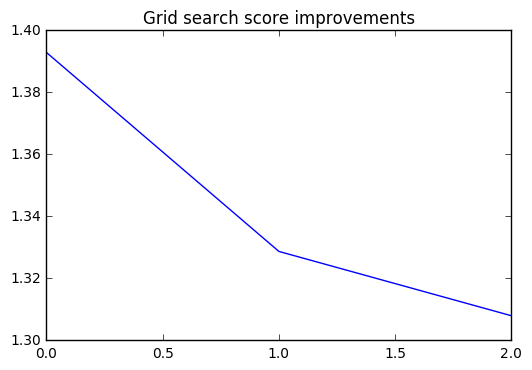

In [43]:
plt.plot(score_improvements)
plt.title('Grid search score improvements')
plt.show()

In [26]:
best_cfg

{'alpha': 0.025000000000000001,
 'dm': 1,
 'min_alpha': 0.01,
 'min_count': 1,
 'num_epochs': 91,
 'size': 65,
 'window': 6}

In [27]:
best_score

1.2581359159113068